In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras

# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle

import nilearn as nl
from nilearn import plotting, image
from nilearn import datasets
import nibabel as nb
import h5py

import os

import time

Using TensorFlow backend.


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10956898353285573279
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8113992409944468048
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6589725830
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9260765866342505891
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13594915500766043469
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
# fnc_10 = pd.read_csv('00_Data/fnc.csv')
# fnc_10 = fnc_10.head(5)
# for row in fnc_10.iterrows():
#     idx = int(row[1][0])
#     row = row[1][1:]
#     print(row)
#     row.to_csv('00_Data/fnc_csv_norm/{0}.csv'.format(idx))

In [6]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]

In [7]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [8]:
data.isnull().sum()

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

In [9]:
# nulls = data.isnull().sum()
# l = len(data.index)

# nulls['domain1_var1'] / l

In [10]:
data = data.dropna()

In [11]:
print('Dataset length: ', len(data.index))

Dataset length:  5434


In [12]:
# def get_inputs_fnc(idx, labels):
#     df = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
#     X = np.array(df.values).reshape(-1)
#     return X, labels

In [13]:
# def get_inputs_loading(idx, labels):
#     df = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
#     X = np.array(df.values).reshape(-1)
#     return X, labels

In [14]:
def get_inputs(idx, labels):
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)
#     print(X_fnc[0])
#     print(X_loading[0])
#     print(labels[0])
#     print(X_fnc.shape)
#     print(X_loading.shape)
#     print(labels.shape)

#     X_fnc = tf.convert_to_tensor(X_fnc, dtype=tf.float64)
#     X_loading = tf.convert_to_tensor(X_loading, dtype=tf.float64)
#     labels = tf.convert_to_tensor(labels, dtype=tf.float64)
#     X = tf.tuple([X_fnc, X_loading])

#     X = dict()
#     X['input_1'] = X_fnc
#     X['input_2'] = X_loading
    X = (X_fnc, X_loading)
    return X, labels

In [15]:
def map_decorator(func):
    def wrapper(idx, labels):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(func,
                              inp=(idx, labels),
                              Tout=tf.float64)
    return wrapper

In [16]:
def new_py_function(func, inp, Tout, name=None):
    
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,
                                                     expand_composites=True)
        out = func(*reconstructed_inp)
        return tf.nest.flatten(out, expand_composites=True)
    
    flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
    flat_out = tf.py_function(func=wrapped_func, 
                              inp=tf.nest.flatten(inp, expand_composites=True),
                              Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
                              name=name)
    spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, expand_composites=True)
    out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
    return out

def _dtype_to_tensor_spec(v):
    return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
    return v.dtype if isinstance(v, tf.TensorSpec) else v

In [17]:
# def get_dataset(data, batch_size):
#     data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
#                                                data[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']].values))
#     data = data.shuffle(buffer_size=5500, seed=30, reshuffle_each_iteration=True)
    
#     data_fnc = data.map(map_decorator(get_inputs_fnc), 
#                      num_parallel_calls=tf.data.experimental.AUTOTUNE, 
#                      deterministic=True)
#     data_loading = data.map(map_decorator(get_inputs_loading), 
#                      num_parallel_calls=tf.data.experimental.AUTOTUNE, 
#                      deterministic=True)

#     data_fnc = data_fnc.batch(batch_size, drop_remainder=True)
#     data_fnc = data_fnc.prefetch(tf.data.experimental.AUTOTUNE)
    
#     data_loading = data_loading.batch(batch_size, drop_remainder=True)
#     data_loading = data_loading.prefetch(tf.data.experimental.AUTOTUNE)
#     return (data_fnc, data_loading)

In [18]:
def get_dataset(data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
                                               data[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']].values))
    data = data.shuffle(buffer_size=5500, seed=30, reshuffle_each_iteration=True)
    
    data = data.map(lambda idx, lbl:new_py_function(get_inputs, inp=(idx, lbl), Tout=((tf.float64, tf.float64), tf.float64), name=None), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=True)
    data = data.batch(batch_size, drop_remainder=True)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [19]:
train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=True, random_state=30)
train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [20]:
# batch_size = 64

# ds_train_fnc, ds_train_loading = get_dataset(train, batch_size)
# ds_val_fnc, ds_val_loading = get_dataset(val, batch_size)
# ds_test_fnc, ds_test_loading = get_dataset(test, batch_size)

In [21]:
batch_size = 64

ds_train = get_dataset(train, batch_size)
ds_val = get_dataset(val, batch_size)
ds_test = get_dataset(test, batch_size)

In [22]:
# start_time = time.perf_counter()
# for f in ds_train.take(1):
#     pass
# tf.print("Execution time:", time.perf_counter() - start_time)

In [23]:
INPUT_SHAPE_fnc = (1378,)

In [24]:
INPUT_SHAPE_loading = (26,)

In [25]:
inputs_fnc = keras.layers.Input(shape=INPUT_SHAPE_fnc, name='inp_fnc')

x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(inputs_fnc)
x = keras.layers.Dense(2048,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)
# x = keras.layers.Dropout(rate=0.2, seed=30)(x)

x1 = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x1)
# x1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                           beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
#                                           moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                                           beta_constraint=None, gamma_constraint=None)(x1)

x11 = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x1)
x11 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x11)
x11 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x11)


x12 = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x1)
x12 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x12)
x12 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x12)

x1 = keras.layers.concatenate([x11, x12])

x1 = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x1)
x1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x1)
x1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x1)

x2 = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x2)
# x2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                           beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
#                                           moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                                           beta_constraint=None, gamma_constraint=None)(x2)

x21 = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x2)
x21 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x21)
x21 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x21)

x22 = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x2)
x22 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x22)
x22 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x22)

x2 = keras.layers.concatenate([x21, x22])

x2 = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x2)
x2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x2)
x2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x2)

x = keras.layers.concatenate([x1, x2])

# x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                           beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
#                                           moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                                           beta_constraint=None, gamma_constraint=None)(x)

x = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)

# output
x = keras.Model(inputs=inputs_fnc, outputs=x, name='model_fnc')

In [26]:
inputs_loading = keras.layers.Input(shape=INPUT_SHAPE_loading, name='inp_load')

y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(inputs_loading)

y = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)
# y = keras.layers.Dropout(rate=0.2, seed=30)(y)

y1 = keras.layers.Dense(128,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y1)
y1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(y1)

y2 = keras.layers.Dense(128,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y2)
y2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(y2)

y = keras.layers.concatenate([y1, y2])

# y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                           beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
#                                           moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                                           beta_constraint=None, gamma_constraint=None)(y)

y = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)
# x = keras.layers.Dropout(rate=0.2, seed=30)(x)

# output
y = keras.Model(inputs=inputs_loading, outputs=y, name='model_loading')

In [27]:
concat = keras.layers.concatenate([x.output, y.output])

z1 = keras.layers.Dense(512, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat)
z1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z1)
z1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(z1)

z2 = keras.layers.Dense(512, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat)
z2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z2)
z2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(z2)

z = keras.layers.concatenate([z1, z2])

z = keras.layers.Dense(512, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(z)
z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

outputs = keras.layers.Dense(5, activation='linear')(z)

model = keras.Model(inputs=[x.input, y.input], outputs=outputs, name='model_combined')

In [28]:
model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_fnc (InputLayer)            [(None, 1378)]       0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1378)         5512        inp_fnc[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         2824192     batch_normalization[0][0]        
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 2048)         2048        dense[0][0]                      
_____________________________________________________________________________________

In [29]:
# optim = keras.optimizers.Adam(lr=0.000001,
#                                  beta_1=0.99,
#                                  beta_2=0.999,
#                                  amsgrad=False)

optim = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)
        
METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
           keras.metrics.MeanSquaredError(name='mse'),
           keras.metrics.MeanAbsoluteError(name='mae')]

In [30]:
# def weighted_mae(y_true, y_pred):
# #     tf.print(y_true)
#     W = tf.constant([[0.2, 0.2, 0.2, 0.2, 0.2]])
# #     tf.print(W / tf.math.reduce_mean(y_true, axis=0))
#     return tf.math.reduce_mean(tf.linalg.matmul(tf.math.abs(y_pred - y_true), tf.transpose(W / tf.math.reduce_mean(y_true, axis=0))), axis=0)

In [31]:
model.compile(loss='mae', metrics=METRICS, optimizer=optim)

In [32]:
# Define the checkpoint directory to store the checkpoints
# Name of the checkpoint files
# checkpoint_prefix = os.path.join('./99_Training_checkpoints/fnc-loading', "ckpt_{epoch}")

In [33]:
# callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/fnc-loading'),
#              tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                                 save_weights_only=False),
#              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                                   factor=0.7, 
#                                                   patience=2, 
#                                                   verbose=1, 
#                                                   mode='min',
#                                                   min_delta=0.01, 
#                                                   cooldown=5, 
#                                                   min_lr=0.00000001),
#              tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                               min_delta=0.001, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=True)]

In [34]:
# callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/fnc-loading'),
#              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                                   factor=0.7, 
#                                                   patience=2, 
#                                                   verbose=1, 
#                                                   mode='min',
#                                                   min_delta=0.01, 
#                                                   cooldown=5, 
#                                                   min_lr=0.00000001),
#              tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                               min_delta=0.001, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=True)]

In [35]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/fnc-loading'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=10, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [36]:
# def decay(epoch):
#     if epoch < 2:
#         return 0.01
#     elif epoch >= 2 and epoch < 10:
#         return 0.005
#     else:
#         return 1e-4

In [37]:
# callbacks = [tf.keras.callbacks.LearningRateScheduler(decay)]

In [38]:
with tf.device('/GPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     callbacks=callbacks,
                     epochs=400,
                     verbose=1)

Epoch 1/400
54/54 [==============================] - 15s 279ms/step - loss: 56.7213 - rmse: 58.6116 - mse: 3435.3198 - mae: 56.7213 - val_loss: 58.4808 - val_rmse: 60.7992 - val_mse: 3696.5386 - val_mae: 58.4808
Epoch 2/400
54/54 [==============================] - 15s 270ms/step - loss: 56.4966 - rmse: 58.3944 - mse: 3409.9067 - mae: 56.4966 - val_loss: 57.2289 - val_rmse: 59.1667 - val_mse: 3500.7007 - val_mae: 57.2289
Epoch 3/400
54/54 [==============================] - 15s 277ms/step - loss: 56.2706 - rmse: 58.1750 - mse: 3384.3291 - mae: 56.2706 - val_loss: 56.4340 - val_rmse: 58.3027 - val_mse: 3399.2100 - val_mae: 56.4340
Epoch 4/400
54/54 [==============================] - 15s 277ms/step - loss: 56.0155 - rmse: 57.9293 - mse: 3355.8081 - mae: 56.0155 - val_loss: 56.0044 - val_rmse: 57.8825 - val_mse: 3350.3804 - val_mae: 56.0044
Epoch 5/400
54/54 [==============================] - 15s 274ms/step - loss: 55.7619 - rmse: 57.6836 - mse: 3327.3958 - mae: 55.7619 - val_loss: 55.5579 

In [39]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

16/16 [==============================] - 3s 200ms/step - loss: 8.4272 - rmse: 10.7324 - mse: 115.1843 - mae: 8.4272


Text(0.5, 1.0, 'Metric')

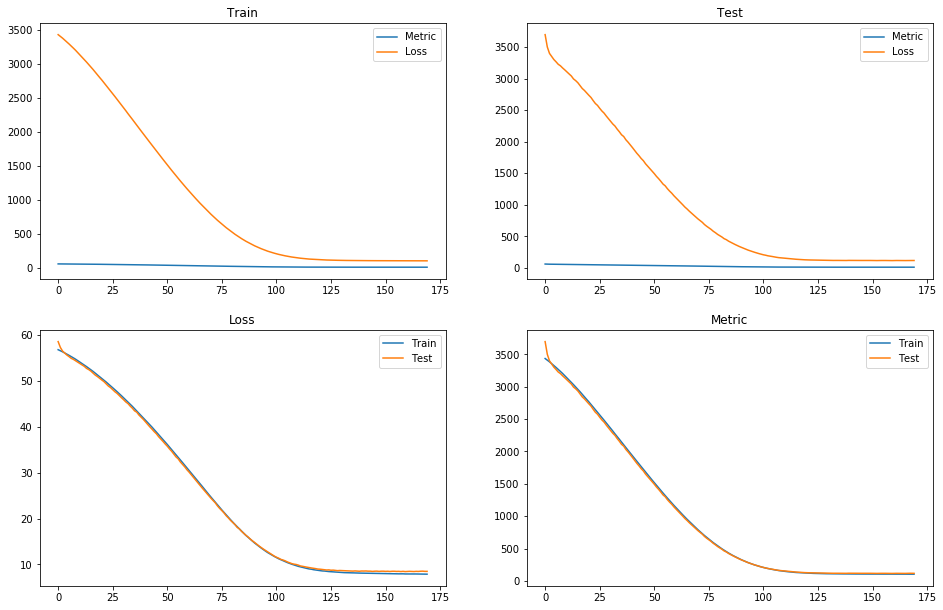

In [40]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [41]:
X1_test = pd.read_csv('00_Data/fnc.csv')
X1_test = X1_test[X1_test['Id'].isin(TEST_IDS)]
X1_test = X1_test.to_numpy()
X1_test = X1_test[:,1:]

In [42]:
X2_test = pd.read_csv('00_Data/loading.csv')
X2_test = X2_test[X2_test['Id'].isin(TEST_IDS)]
X2_test = X2_test.to_numpy()
X2_test = X2_test[:,1:]

In [43]:
y_preds = model.predict([X1_test, X2_test])

In [44]:
y_preds = y_preds.flatten()

In [45]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [46]:
df_submission.to_csv('submission_fnc-load_mae_09.csv', index=False)

In [7]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [28]:
data_nulls = data[data.isnull().any(axis=1)]
NULL_IDS = list(data_nulls['Id'].values)